# Detaillierte Analyse im Bezug auf gesellschaftliche Abstimmungen

## Importiere notwendige Bibliotheken

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

## Datensatz vorbereiten

In [6]:
# Lade den Datensatz
df = pd.read_csv('./data/dataset.csv', sep=';', low_memory=False)

# Konvertiere Datumsspalte in datetime-Format
df['datum'] = pd.to_datetime(df['datum'], format='%d.%m.%Y', errors='coerce')
df['year'] = df['datum'].dt.year

## Extraktion von gesellschaftlich Orientierten Abstimmungen

### Definition
Gesellschaftsorientierte Abstimmungen sind Volks- und Parlamentsentscheidungen, die unmittelbar auf das soziale Zusammenleben, die Grundrechte oder die kollektive Infrastruktur einer Gesellschaft abzielen. Typische Merkmale sind:

- Betroffenheit breiter Bevölkerungsschichten (z. B. Familien, ältere Menschen, sozial Schwächere)
- Regelung von Grundrechten und Bürgerpflichten (z. B. Gleichstellung, Partizipation)
- Gestaltung von Bildung, Gesundheit und sozialer Sicherheit (z. B. Pflege, Sozialversicherungen)
- Förderung von Integration, Inklusion und Zusammenhalt (z. B. Migration, Sprachförderung)

Im Unterschied dazu stehen fiskalische, infrastrukturelle oder rein ökonomische Vorlagen (z. B. Steuerfragen, Strassenbau, Handelspolitik).

### Keywords
Aufgrund unserer obigen Definition, definieren wir folgende Liste als unsere Keywords, zum herausfiltern von gesellschaftsorientierten Abstimmungen:

| Themenbereich                       | Filter-Keywords                                                                 |
| ---------------------------------- | ------------------------------------------------------------------------------ |
| Soziales & Wohlfahrt               | sozialhilfe, fürsorge, mieterschutz, mietrecht, mieter, sozialversicherung, sozialversicherungen, pflegefinanzierung, pflegeversicherung |
| Familie & Generationen            | alters, rentenalters, familienzulagen, elternurlaub, eltern, elternschaft, familienpolitik, generationen, jugend, jugendschutz, kinder |
| Gesundheit & Pflege               | krankenversicherung, gesundheitswesen, spitalfinanzierung, mutterschaftsversicherung, mutterschaftsurlaub, pflegefinanzierung, pflegeversicherung |
| Gleichstellung & Rechte           | frau, gleichstellung, menschenrechte, bürgerrechte, zivilstand                |
| Integration & Migration           | asylgesetz, migrationsfragen, einbürgerung, integrationsgesetz, sprachförderung |
| Bildung & Kultur                  | bildung, schulgesetz                                                          |
| Partizipation & Demokratie        | volksrechte, zusammenleben                                                   |
| Arbeitswelt & soziale Sicherung   | arbeitnehmende, hinterlassenenversicherung, betreuungsgutschriften           |

Wir definieren auch eine Liste mit Keywords, die in gesellschaftsorientierten Abstimmungen nicht vorkommen dürfen, damit wir falsch positive Ergebnisse vermeiden:

| Themenbereich                       | Filter-Keywords                                                                 |
| ---------------------------------- | ------------------------------------------------------------------------------ |
| Steuern & Finanzen                | finanzordnung, mehrwertsteuer, besteuerung, steuerharmonisierung, mwst, gewinnsteuer, einkommensteuer, bundesfinanzen, bundeshaushalt |
| Verkehr & Infrastruktur           | nationalstrassen, strassenbau, verkehrsinfrastruktur, strassentransit, bahnverkehr, verkehr, ausbau |
| Energie & Telekommunikation       | energiepolitik, elektrizitätsversorgung, stromversorgung, telekommunikation   |
| Wirtschaft & Handel               | wirtschaftsartikel, wirtschaftspolitik, finanzmarkt, zollgesetz, gewinn, aktiengesellschaften, import, export, zölle, bankengesetz |
| Militär & Sicherheit              | militärgesetz, militärdienst, militärorganisation                             |
| Landwirtschaft & Subventionen     | landwirtschaftsgesetz, agrarpolitik, landwirtschaftspolitik, subventionierung |


In [ ]:

# Definiere Schlüsselwörter für gesellschaftsorientierte Abstimmungen
social_keywords = [
    'alters', 'hinterlassenenversicherung', 'asylgesetz', 'rentenalters',
    'einbürgerung', 'mieter', 'mieterschutz', 'soziale',
    'mutterschaftsversicherung', 'frau', 'familienzulagen', 'migrationsfragen',
    'sozialversicherung', 'jugend', 'gleichstellung', 'behinderten',
    'integrationsgesetz', 'elternurlaub', 'ehepaaren', 'bürgerrechte',
    'spitalfinanzierung', 'eltern', 'krankenversicherung', 'gesundheitswesen',
    'pflegefinanzierung', 'pflegeversicherung', 'mutterschaftsurlaub', 
    'sozialversicherungen', 'arbeitnehmende', 'volksrechte', 'zivilstand',
    'zusammenleben', 'betreuungsgutschriften', 'generationen', 
    'elternschaft', 'sozialhilfe', 'fürsorge', 'menschenrechte', 
    'familienpolitik', 'mietrecht', 'jugendschutz', 'schulgesetz',
    'sprachförderung', 'bildung', 'kinder'
]

# Definiere Schlüsselwörter für nicht gesellschaftsorientierte Abstimmungen
non_social_keywords = [
    'finanzordnung', 'finanzierung', 'einer', 'mehrwertsteuer',
    'einführung', 'schwerverkehrsabgabe', 'eines', 'ausbau',
    'nationalstrassen', 'besteuerung', 'strassenbau', 'verkehrsinfrastruktur',
    'strassentransit', 'bahnverkehr', 'verkehr', 'energiepolitik',
    'elektrizitätsversorgung', 'wirtschaftsartikel', 'wirtschaftspolitik',
    'telekommunikation', 'zollgesetz', 'stromversorgung', 'finanzmarkt',
    'steuerharmonisierung', 'unternehmenssteuer', 'subventionierung',
    'mwst', 'steuerartikel', 'gewinnsteuer', 'aktiengesellschaften',
    'gewinn', 'einkommensteuer', 'bundesfinanzen', 'militärgesetz',
    'militärdienst', 'landwirtschaftsgesetz', 'landwirtschaftspolitik',
    'militärorganisation', 'agrarpolitik', 'zölle', 'import', 'export',
    'währungsfonds', 'bundeshaushalt', 'bankengesetz'
]

# Erstelle eine Funktion zur Identifizierung gesellschaftsorientierter Abstimmungen
def is_society_oriented(row):
    # Kombiniere relevante Textspalten für die Suche
    text = ' '.join([
        str(row.get('titel_kurz_d', '')).lower(),
        str(row.get('titel_off_d', '')).lower(),
        str(row.get('text_d', '')).lower()
    ])

    if any(keyword in text for keyword in social_keywords):
        if any(keyword in text for keyword in non_social_keywords):
            return False
        else:
            return True
    return False

# Identifiziere gesellschaftsorientierte Abstimmungen
df['society_oriented'] = df.apply(is_society_oriented, axis=1)

# Extrahiere nur gesellschaftsorientierte Abstimmungen
society_votes = df[df['society_oriented'] == True].copy()

# Speichere als CSV mit gleicher Struktur wie das Original
society_votes.to_csv('./data/gesellschaftliche_abstimmungen.csv', sep=';', index=False)

print(f"Extrahiert: {len(society_votes)} gesellschaftsorientierte Abstimmungen von insgesamt {len(df)} Abstimmungen")
print(f"Prozentsatz: {len(society_votes)/len(df)*100:.2f}%")

Extrahiert: 84 gesellschaftsorientierte Abstimmungen von insgesamt 696 Abstimmungen
Prozentsatz: 12.07%


## Ranking der Kantone nach Liberalität/Konservativität
### Definition
Wir haben folgende Definition für die Liberalität eines Kantons definiert:
Ein Kanton wird als liberal im Abstimmungsverhalten bezeichnet, wenn er überdurchschnittlich häufig gesellschaftspolitisch progressive oder wirtschaftlich marktoffene Vorlagen unterstützt, insbesondere im Vergleich zum nationalen Durchschnitt.

### Qualitative Schwelle
Ein Kanton gilt als sozialliberal wenn er überdurchschnittlich für folgende Vorlagen mit "Ja" stimmt:
- Gleichstellungsvorlagen (z. B. Ehe für alle, Antidiskriminierung)
- Migration und Integration
- Ausbau von Grundrechten und Partizipation
- Reformen im Bildungs- und Gesundheitswesen
- Liberalisierungen bei individuellen Freiheitsrechten (z. B. Abtreibung, Sterbehilfe)

### Quantitative Schwelle
- Der Kanton stimmt in mindestens 60 % aller nationalen Abstimmungen, bei denen ein liberaler Gegensatz erkennbar ist, im Sinne der liberalen Position (gemäss obiger Definitionen).
- Der Kanton weicht bei diesen Vorlagen mindestens 10 Prozentpunkte vom nationalen Ja-/Nein-Anteil in Richtung der liberalen Position ab.


Wir erstellen ein Python Skript, welches uns erlaubt, manuell zu kontrollieren, ob die Abstimmungen liberal sind oder nicht.

In [ ]:
# Dateipfade
input_file  = "data/gesellschaftliche_abstimmungen.csv"
output_file = "data/gesellschaftliche_abstimmungen_annotiert.csv"

# Input laden
df = pd.read_csv(input_file, sep=";")

# Nur einmal den Header in die neue Datei schreiben
df.head(0).to_csv(output_file, sep=";", index=False)

# Durch alle Abstimmungen iterieren
for idx, row in df.iterrows():
    print("\n" + "-"*60)
    print(f"[{idx+1}/{len(df)}] Datum: {row['datum']}")
    print(f"Titel kurz : {row['titel_kurz_d']}")
    print(f"Beschreibung: {row['titel_off_d']}")
    print("Liberale Position? [j]a / [n]ein / [s]kip / [q]uit")

    while True:
        eingabe = input("Eingabe: ").strip().lower()
        if eingabe == "j":
            # Nur die Zeile anhängen, ohne Header
            row.to_frame().T.to_csv(
                output_file,
                sep=";",
                mode="a",
                index=False,
                header=False
            )
            break
        elif eingabe in ("n", "s"):
            # nichts tun, nächste Zeile
            break
        elif eingabe == "q":
            print("Abbruch durch Nutzer. Datei wurde bis hierhin gefüllt.")
            sys.exit(0)
        else:
            print("Ungültige Eingabe. Bitte j / n / s / q verwenden.")

print("\nFertig. Datei mit allen mit 'j' markierten Abstimmungen:")
print(f"  {output_file}")


------------------------------------------------------------
[1/84] Datum: 1866-01-14
Titel kurz : Gleichstellung der Juden und Naturalisierten mit Bezug auf Niederlassung
Beschreibung: Gleichstellung der Juden und Naturalisierten mit Bezug auf Niederlassung
Liberale Position? [j]a / [n]ein / [s]kip / [q]uit

------------------------------------------------------------
[2/84] Datum: 1875-05-23
Titel kurz : Gesetz betreffend Feststellung und Beurkundung des Zivilstandes und die Ehe
Beschreibung: Bundesgesez betreffend Feststellung und Beurkundung des Zivilstandes und die Ehe
Liberale Position? [j]a / [n]ein / [s]kip / [q]uit

------------------------------------------------------------
[3/84] Datum: 1890-10-26
Titel kurz : Gesetzgebungsrecht über die Unfall- und Krankenversicherung
Beschreibung: Bundesbeschluss betreffend Ergänzung der Bundesverfassung vom 29. Mai 1874 durch einen Zusatz bezüglich des Gesetzgebungsrechtes über Unfall- und Krankenversicherung
Liberale Position? [j]a / [

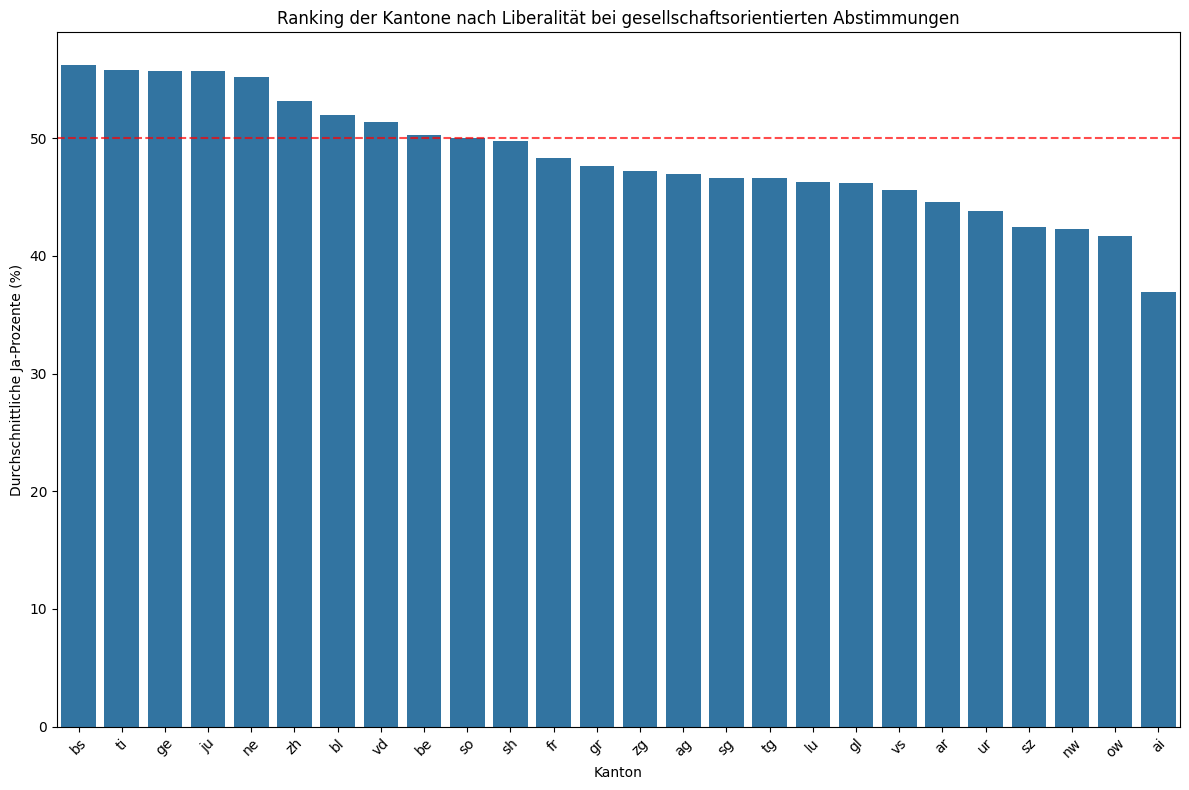

Ranking der Kantone nach Liberalität (höhere Ja-Prozente = liberaler):


,Kanton,Durchschnittliche_Ja_Prozente
11,bs,56.186316
20,ti,55.766842
24,ge,55.703509
25,ju,55.693171
23,ne,55.174035
0,zh,53.162807
12,bl,51.976140
21,vd,51.364912
1,be,50.271053
10,so,50.019474


In [6]:
# Lade die extrahierten gesellschaftsorientierten Abstimmungen
society_votes = pd.read_csv('./data/gesellschaftliche_abstimmungen_annotiert.csv', sep=';', low_memory=False)

# Identifiziere alle Kantonsspalten (Format: 'kanton-japroz')
canton_cols = [col for col in society_votes.columns if col.endswith('-japroz')]
cantons = [col.split('-')[0] for col in canton_cols]

# Konvertiere alle kantonalen Ja-Prozent-Spalten zu numerischen Werten
for col in canton_cols:
    society_votes[col] = pd.to_numeric(society_votes[col], errors='coerce')

# Berechne durchschnittliche Ja-Prozente pro Kanton über alle gesellschaftsorientierten Abstimmungen
canton_means = {}
for canton, col in zip(cantons, canton_cols):
    canton_means[canton] = society_votes[col].mean()

# Erstelle ein DataFrame für das Ranking
canton_ranking = pd.DataFrame({
    'Kanton': cantons,
    'Durchschnittliche_Ja_Prozente': [canton_means[canton] for canton in cantons]
})

# Sortiere nach Ja-Prozenten (absteigend für liberalste zuerst)
canton_ranking = canton_ranking.sort_values('Durchschnittliche_Ja_Prozente', ascending=False)

# Visualisiere das Ranking
plt.figure(figsize=(12, 8))
sns.barplot(data=canton_ranking, x='Kanton', y='Durchschnittliche_Ja_Prozente')
plt.title('Ranking der Kantone nach Liberalität bei gesellschaftsorientierten Abstimmungen')
plt.xlabel('Kanton')
plt.ylabel('Durchschnittliche Ja-Prozente (%)')
plt.xticks(rotation=45)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)  # 50% Schwellenlinie
plt.tight_layout()
plt.show()

# Zeige das Ranking als Tabelle
print("Ranking der Kantone nach Liberalität (höhere Ja-Prozente = liberaler):")
display(canton_ranking)

## Datum Standardisieren
Damit Pandas mit der CSV-Datei arbeiten kann, müssen wir das Datum in ein Format konvertieren, welches Pandas versteht.

In [7]:
# Lade die extrahierten gesellschaftsorientierten Abstimmungen
society_votes = pd.read_csv('./data/gesellschaftliche_abstimmungen_annotiert.csv', sep=';', low_memory=False)

# Format ist YYYY-MM-DD
society_votes['datum'] = pd.to_datetime(society_votes['datum'], format='%Y-%m-%d', errors='coerce')

# Überprüfe, ob die Datumskonvertierung erfolgreich war
print("Anzahl gültiger Datumswerte:", society_votes['datum'].notna().sum())
print("Anzahl fehlender Datumswerte:", society_votes['datum'].isna().sum())


society_votes['year'] = society_votes['datum'].dt.year
print("Anzahl gültiger Datumswerte:", society_votes['datum'].notna().sum())

# Überprüfe, ob die Jahreswerte sinnvoll sind
year_range = society_votes['year'].dropna()
if not year_range.empty:
    print(f"Jahresbereich: {year_range.min()} bis {year_range.max()}")

Anzahl gültiger Datumswerte: 61
Anzahl fehlender Datumswerte: 0
Anzahl gültiger Datumswerte: 61
Jahresbereich: 1866 bis 2024


## Unterteilung in Perioden
Wir unterteilen die Datenpunkte in Perioden, damit sich die Analyse leserlich gestaltet.

In [9]:
# Definiere Zeitperioden für die Analyse nur für Zeilen mit gültigen Jahren
society_votes['period'] = None  # Initialisiere mit None
mask = society_votes['year'].notna()
if mask.any():
    try:
        society_votes.loc[mask, 'period'] = pd.cut(
            society_votes.loc[mask, 'year'],
            bins=[1800, 1950, 1980, 2000, 2025],
            labels=['bis 1950', '1951-1980', '1981-2000', '2001-Heute']
        )
    except Exception as e:
        print(f"Fehler bei der Erstellung der Perioden: {e}")
        # Alternative: Manuelle Zuweisung der Perioden
        def assign_period(year):
            if pd.isna(year):
                return None
            elif year <= 1950:
                return 'bis 1950'
            elif year <= 1980:
                return '1951-1980'
            elif year <= 2000:
                return '1981-2000'
            else:
                return '2001-heute'

        society_votes['period'] = society_votes['year'].apply(assign_period)

# Überprüfe die Periodenverteilung
print("Verteilung der Perioden:")
print(society_votes['period'].value_counts(dropna=False))

Verteilung der Perioden:
period
2001-Heute    27
1981-2000     17
1951-1980      9
bis 1950       8
Name: count, dtype: int64


## Identifizierung für die Ja-Werte

In [10]:
  # Identifiziere die Spalten für kantonale Ja-Prozente
canton_japroz_cols = [col for col in society_votes.columns if col.endswith('-japroz')]
cantons = [col.split('-')[0] for col in canton_japroz_cols]
print(f"Gefundene Kantone: {len(cantons)}")

# Konvertiere alle kantonalen Ja-Prozent-Spalten zu numerischen Werten
for col in canton_japroz_cols:
    society_votes[col] = pd.to_numeric(society_votes[col], errors='coerce')

# Überprüfe, ob Daten in den Ja-Prozent-Spalten vorhanden sind
data_available = {col: society_votes[col].notna().sum() for col in canton_japroz_cols}
print("Anzahl der verfügbaren Datenpunkte pro Kanton:")
for col, count in data_available.items():
    if count > 0:
        print(f"{col}: {count} Datenpunkte")

Gefundene Kantone: 26
Anzahl der verfügbaren Datenpunkte pro Kanton:
zh-japroz: 57 Datenpunkte
be-japroz: 57 Datenpunkte
lu-japroz: 57 Datenpunkte
ur-japroz: 57 Datenpunkte
sz-japroz: 57 Datenpunkte
ow-japroz: 57 Datenpunkte
nw-japroz: 57 Datenpunkte
gl-japroz: 57 Datenpunkte
zg-japroz: 57 Datenpunkte
fr-japroz: 57 Datenpunkte
so-japroz: 57 Datenpunkte
bs-japroz: 57 Datenpunkte
bl-japroz: 57 Datenpunkte
sh-japroz: 57 Datenpunkte
ar-japroz: 57 Datenpunkte
ai-japroz: 57 Datenpunkte
sg-japroz: 57 Datenpunkte
gr-japroz: 57 Datenpunkte
ag-japroz: 57 Datenpunkte
tg-japroz: 57 Datenpunkte
ti-japroz: 57 Datenpunkte
vd-japroz: 57 Datenpunkte
vs-japroz: 57 Datenpunkte
ne-japroz: 57 Datenpunkte
ge-japroz: 57 Datenpunkte
ju-japroz: 41 Datenpunkte


## Analyse der Veränderungen in den Kantonen über die Zeit

### Veränderung über die Zeit

In [11]:
# Berechne die Veränderung für jeden Kanton über die Zeit
canton_changes = {}
for canton in cantons:
    col = f'{canton}-japroz'

    # Überprüfe, ob genügend Daten für diesen Kanton vorhanden sind
    if society_votes[col].notna().sum() < 10:  # Mindestens 10 Datenpunkte erforderlich
        print(f"Zu wenige Daten für Kanton {canton}: {society_votes[col].notna().sum()} Datenpunkte")
        continue

    # Berechne den Mittelwert pro Zeitperiode
    try:
        # Versuche zuerst mit observed=True (für kategorische Daten)
        period_means = society_votes.groupby('period', observed=True)[col].mean()
    except:
        # Falls das nicht funktioniert, versuche ohne observed Parameter
        try:
            period_means = society_votes.groupby('period')[col].mean()
        except Exception as e:
            print(f"Fehler bei der Gruppierung für Kanton {canton}: {e}")
            continue

    print(f"Mittelwerte für {canton}:")
    print(period_means)

    # Berechne die Gesamtveränderung (neueste minus älteste Periode)
    if len(period_means) >= 2 and not period_means.isna().all():
        # Finde die erste und letzte nicht-NaN Periode
        valid_periods = period_means.dropna()
        if len(valid_periods) >= 2:
            first_valid_idx = valid_periods.index[0]
            last_valid_idx = valid_periods.index[-1]

            print(f"Erste gültige Periode: {first_valid_idx}, Letzte gültige Periode: {last_valid_idx}")
            print(f"Wert erste Periode: {valid_periods[first_valid_idx]}, Wert letzte Periode: {valid_periods[last_valid_idx]}")

            total_change = valid_periods[last_valid_idx] - valid_periods[first_valid_idx]
            canton_changes[canton] = total_change
            print(f"Kanton {canton} hat eine Gesamtveränderung von {total_change:.2f} Prozentpunkten.")
        else:
            print(f"Nicht genügend gültige Perioden für Kanton {canton}")


Mittelwerte für zh:
period
1951-1980     53.518889
1981-2000     47.761176
2001-Heute    53.603478
bis 1950      62.973750
Name: zh-japroz, dtype: float64
Erste gültige Periode: 1951-1980, Letzte gültige Periode: bis 1950
Wert erste Periode: 53.51888888888889, Wert letzte Periode: 62.97375
Kanton zh hat eine Gesamtveränderung von 9.45 Prozentpunkten.
Mittelwerte für be:
period
1951-1980     50.735556
1981-2000     45.947647
2001-Heute    53.066957
bis 1950      50.897500
Name: be-japroz, dtype: float64
Erste gültige Periode: 1951-1980, Letzte gültige Periode: bis 1950
Wert erste Periode: 50.73555555555556, Wert letzte Periode: 50.8975
Kanton be hat eine Gesamtveränderung von 0.16 Prozentpunkten.
Mittelwerte für lu:
period
1951-1980     47.086667
1981-2000     42.844706
2001-Heute    51.945217
bis 1950      36.205000
Name: lu-japroz, dtype: float64
Erste gültige Periode: 1951-1980, Letzte gültige Periode: bis 1950
Wert erste Periode: 47.08666666666667, Wert letzte Periode: 36.205
Kanton

### Visualisierung der Veränderung

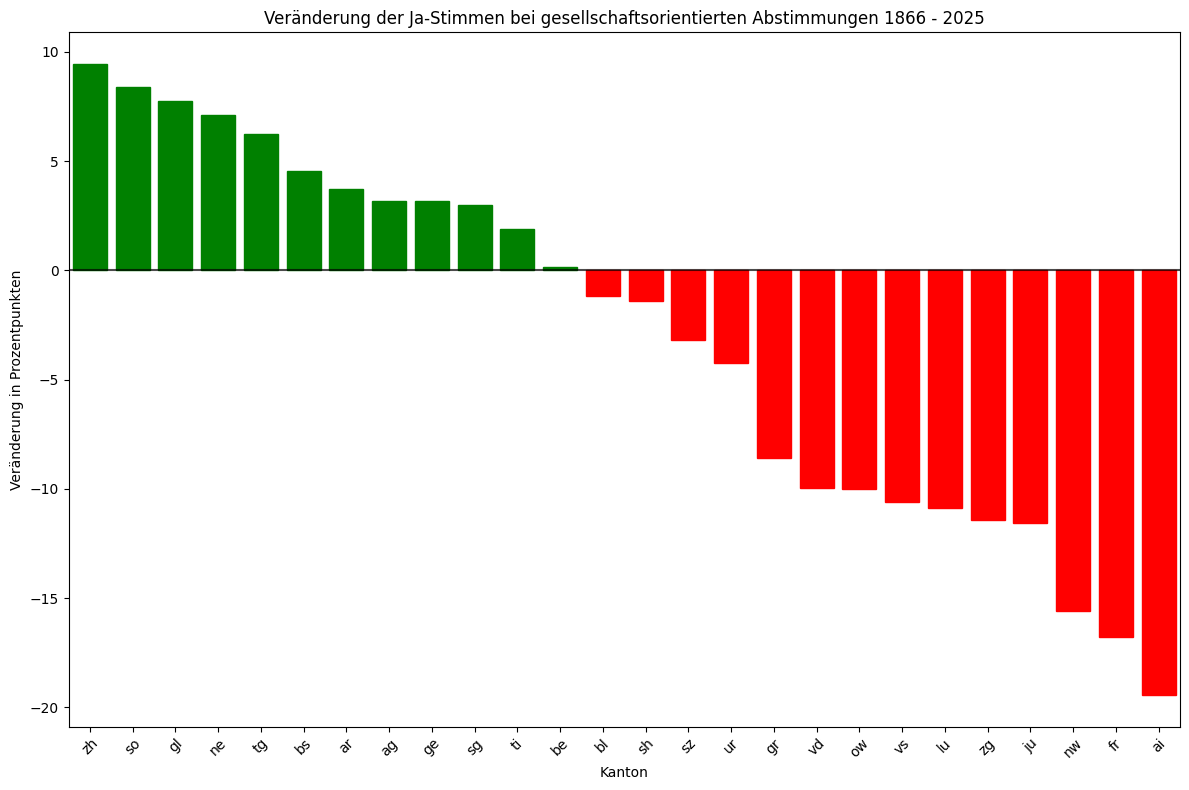

In [15]:
if canton_changes:
    # Erstelle ein DataFrame für die Veränderungen
    change_df = pd.DataFrame({
        'Kanton': list(canton_changes.keys()),
        'Veränderung_Prozentpunkte': list(canton_changes.values())
    })

    # Sortiere nach Veränderung (absteigend)
    change_df = change_df.sort_values('Veränderung_Prozentpunkte', ascending=False)

    # Visualisiere die Veränderungen
    plt.figure(figsize=(12, 8))

    try:
        # Versuche mit dem neueren seaborn API
        bars = sns.barplot(x='Kanton', y='Veränderung_Prozentpunkte', data=change_df)

        # Färbe die Balken je nach positiver oder negativer Veränderung
        for i, bar in enumerate(bars.patches):
            if change_df.iloc[i]['Veränderung_Prozentpunkte'] > 0:
                bar.set_color('green')
            else:
                bar.set_color('red')
    except:
        # Fallback für ältere seaborn Versionen
        try:
            bars = sns.barplot(data=change_df, x='Kanton', y='Veränderung_Prozentpunkte')

            # Färbe die Balken je nach positiver oder negativer Veränderung
            for i, bar in enumerate(bars.patches):
                if change_df.iloc[i]['Veränderung_Prozentpunkte'] > 0:
                    bar.set_color('green')
                else:
                    bar.set_color('red')
        except Exception as e:
            print(f"Fehler bei der Erstellung des Barplots: {e}")
            # Einfacher Fallback ohne Farbcodierung
            plt.bar(change_df['Kanton'], change_df['Veränderung_Prozentpunkte'])

    plt.title('Veränderung der Ja-Stimmen bei gesellschaftsorientierten Abstimmungen 1866 - 2025')
    plt.xlabel('Kanton')
    plt.ylabel('Veränderung in Prozentpunkten')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
    plt.tight_layout()
    plt.show()

['zh', 'be', 'lu', 'ur', 'sz', 'ow', 'nw', 'gl', 'zg', 'fr', 'so', 'bs', 'bl', 'sh', 'ar', 'ai', 'sg', 'gr', 'ag', 'tg', 'ti', 'vd', 'vs', 'ne', 'ge', 'ju']


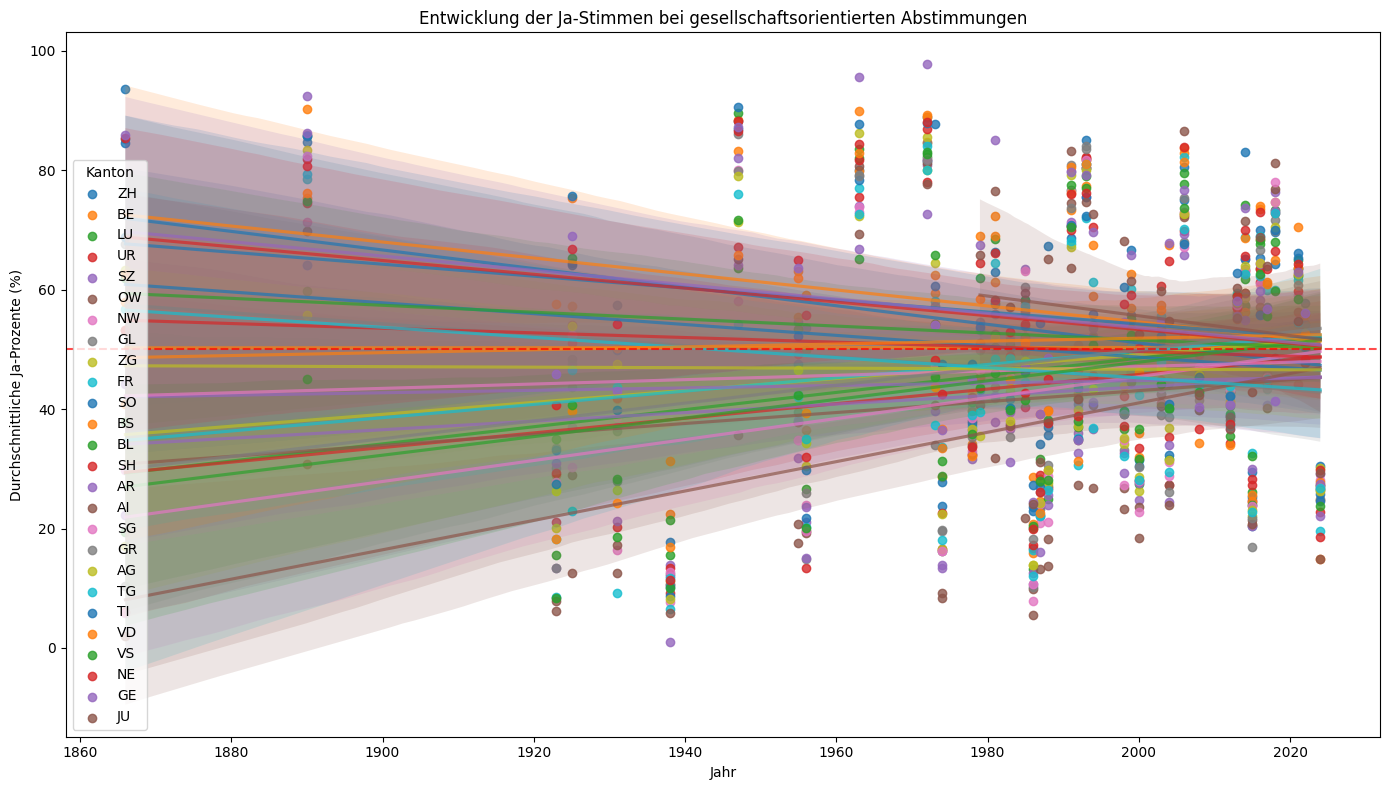

In [16]:
# Detaillierte Analyse der Entwicklung für ausgewählte Kantone
# Wähle Kantone aus, die tatsächlich Daten haben
available_cantons = list(canton_changes.keys())
print(available_cantons)
selected_cantons = ['zh', 'be', 'lu', 'ur', 'sz', 'ow', 'nw', 'gl', 'zg', 'fr', 'so', 'bs', 'bl', 'sh', 'ar', 'ai', 'sg', 'gr', 'ag', 'tg', 'ti', 'vd', 'vs', 'ne', 'ge', 'ju']
selected_cantons = [c for c in selected_cantons if c in available_cantons]

if not selected_cantons:
    # Wenn keiner der bevorzugten Kantone verfügbar ist, nehme die Top-6 mit den größten Veränderungen
    if len(change_df) >= 6:
        selected_cantons = list(change_df['Kanton'].head(3)) + list(change_df['Kanton'].tail(3))
    else:
        selected_cantons = list(change_df['Kanton'])

selected_cols = [f'{canton}-japroz' for canton in selected_cantons]

# Erstelle einen Plot für die Entwicklung über die Zeit
plt.figure(figsize=(14, 8))

for canton, col in zip(selected_cantons, selected_cols):
    # Gruppiere nach Jahr und berechne den Mittelwert
    yearly_data = society_votes.groupby('year')[col].mean().reset_index()
    yearly_data = yearly_data.dropna()  # Entferne Jahre ohne Daten

    if not yearly_data.empty and len(yearly_data) > 1:
        # Plotte die Entwicklung mit Trendlinie
        try:
            sns.regplot(x='year', y=col, data=yearly_data,
                       label=canton.upper(), scatter=True, line_kws={"alpha":0.7})
        except Exception as e:
            print(f"Fehler beim Plotten für Kanton {canton}: {e}")

plt.title('Entwicklung der Ja-Stimmen bei gesellschaftsorientierten Abstimmungen')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittliche Ja-Prozente (%)')
plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)
plt.legend(title='Kanton')
plt.tight_layout()
plt.show()

## Städtische & Ländliche Kantone
Die Zuordnung basiert auf drei wesentlichen Merkmalen:
- Bevölkerungsdichte – Kantone mit hoher Einwohnerzahl pro Quadratkilometer wurden als städtisch eingestuft.
- Urbanisierungsgrad – Kantone, die durch eine oder mehrere grosse Städte oder Agglomerationen geprägt sind (z. B. Zürich, Genf, Lausanne), wurden der Kategorie „städtisch“ zugeordnet.
- Infrastruktur und Zentralität – Kantone mit ausgeprägter wirtschaftlicher und verkehrstechnischer Zentralität (z. B. Sitz grosser Unternehmen, Hochschulen, bedeutender Verkehrsnetze) gelten als städtisch.

In [17]:
# Zusätzliche Analyse: Vergleich zwischen urbanen und ländlichen Kantonen
urban_cantons = ['zh', 'be', 'bs', 'ge', 'vd', 'sg', 'ag', 'lu', 'bl']  # Städtische Kantone
rural_cantons = ['ur', 'sz', 'ow', 'nw', 'gl', 'zg', 'fr', 'so', 'sh',
                 'ar', 'ai', 'gr', 'tg', 'ti', 'vs', 'ne', 'ju'] # Ländliche Kantone

# Filtere auf verfügbare Kantone
available_urban = [c for c in urban_cantons if c in available_cantons]
available_rural = [c for c in rural_cantons if c in available_cantons]

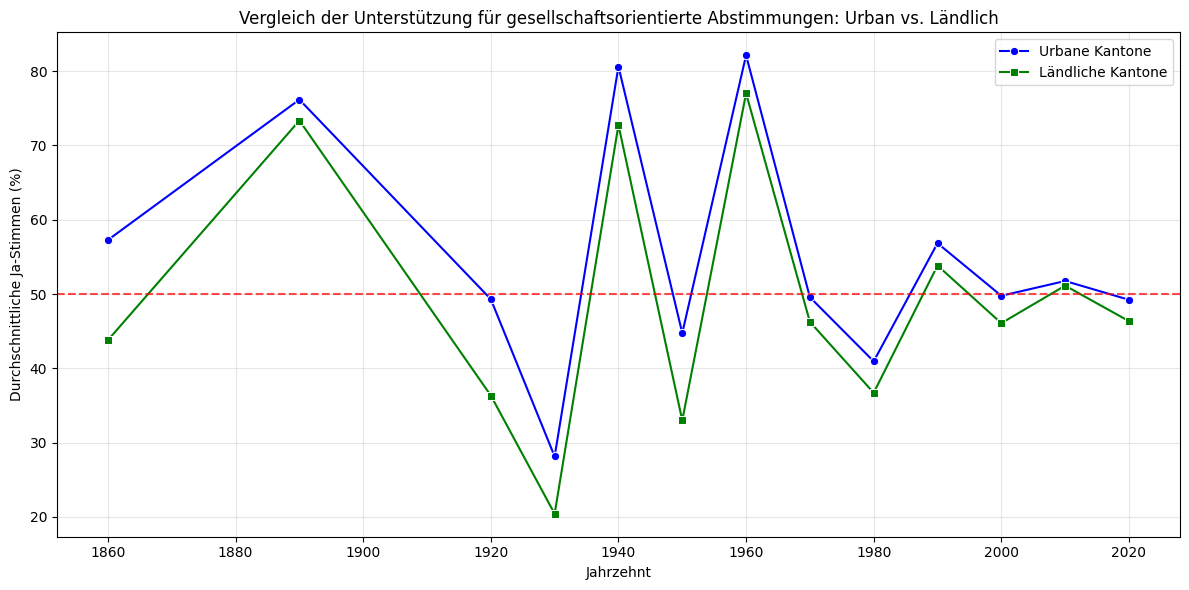

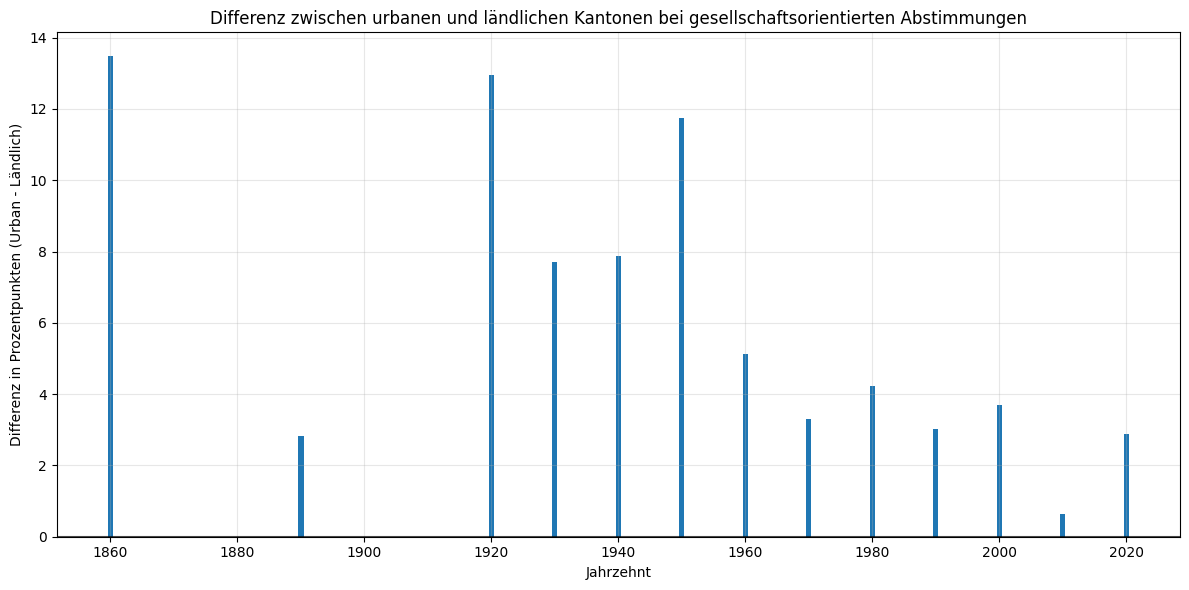

Korrelation zwischen Jahrzehnt und Urban-Rural-Differenz: -0.6810
P-Wert: 0.0104
Es gibt eine statistisch signifikante negative Korrelation zwischen Zeit und Urban-Rural-Differenz.
Dies deutet darauf hin, dass der Unterschied zwischen urbanen und ländlichen Kantonen im Laufe der Zeit abgenommen hat.


In [18]:
if available_urban and available_rural:
    # Berechne durchschnittliche Ja-Prozente für urbane und ländliche Kantone
    society_votes['urban_support'] = society_votes[[f'{c}-japroz' for c in available_urban]].mean(axis=1)
    society_votes['rural_support'] = society_votes[[f'{c}-japroz' for c in available_rural]].mean(axis=1)

    # Gruppiere nach Jahrzehnt für Zeilen mit gültigen Jahren
    mask = society_votes['year'].notna()
    if mask.any():
        society_votes.loc[mask, 'decade'] = (society_votes.loc[mask, 'year'] // 10) * 10

        # Filtere Zeilen mit gültigen Jahrzehnten
        decade_data = society_votes[society_votes['decade'].notna()]

        if not decade_data.empty:
            try:
                urban_rural_by_decade = decade_data.groupby('decade').agg({
                    'urban_support': 'mean',
                    'rural_support': 'mean'
                }).reset_index()

                # Überprüfe, ob genügend Daten für die Visualisierung vorhanden sind
                if not urban_rural_by_decade.empty and urban_rural_by_decade['urban_support'].notna().sum() > 1 and urban_rural_by_decade['rural_support'].notna().sum() > 1:
                    # Visualisiere den Vergleich
                    plt.figure(figsize=(12, 6))

                    # Plotte die Linien für urbane und ländliche Kantone
                    try:
                        sns.lineplot(x='decade', y='urban_support', data=urban_rural_by_decade,
                                    marker='o', label='Urbane Kantone', color='blue')
                        sns.lineplot(x='decade', y='rural_support', data=urban_rural_by_decade,
                                    marker='s', label='Ländliche Kantone', color='green')
                    except Exception as e:
                        print(f"Fehler beim Plotten der Linien: {e}")
                        # Fallback auf einfachere Darstellung
                        plt.plot(urban_rural_by_decade['decade'], urban_rural_by_decade['urban_support'],
                                'o-', label='Urbane Kantone', color='blue')
                        plt.plot(urban_rural_by_decade['decade'], urban_rural_by_decade['rural_support'],
                                's-', label='Ländliche Kantone', color='green')

                    plt.title('Vergleich der Unterstützung für gesellschaftsorientierte Abstimmungen: Urban vs. Ländlich')
                    plt.xlabel('Jahrzehnt')
                    plt.ylabel('Durchschnittliche Ja-Stimmen (%)')
                    plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()

                    # Berechne die Differenz zwischen urbanen und ländlichen Kantonen
                    urban_rural_by_decade['urban_rural_diff'] = urban_rural_by_decade['urban_support'] - urban_rural_by_decade['rural_support']

                    # Visualisiere die Differenz
                    plt.figure(figsize=(12, 6))
                    plt.bar(urban_rural_by_decade['decade'], urban_rural_by_decade['urban_rural_diff'])
                    plt.title('Differenz zwischen urbanen und ländlichen Kantonen bei gesellschaftsorientierten Abstimmungen')
                    plt.xlabel('Jahrzehnt')
                    plt.ylabel('Differenz in Prozentpunkten (Urban - Ländlich)')
                    plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()

                    # Berechne Korrelation zwischen Jahrzehnt und Differenz
                    if len(urban_rural_by_decade) > 2:  # Mindestens 3 Datenpunkte für eine sinnvolle Korrelation
                        correlation, p_value = stats.pearsonr(
                            urban_rural_by_decade['decade'],
                            urban_rural_by_decade['urban_rural_diff']
                        )
                        print(f"Korrelation zwischen Jahrzehnt und Urban-Rural-Differenz: {correlation:.4f}")
                        print(f"P-Wert: {p_value:.4f}")

                        if p_value < 0.05:
                            if correlation > 0:
                                print("Es gibt eine statistisch signifikante positive Korrelation zwischen Zeit und Urban-Rural-Differenz.")
                                print("Dies deutet darauf hin, dass der Unterschied zwischen urbanen und ländlichen Kantonen im Laufe der Zeit zugenommen hat.")
                            else:
                                print("Es gibt eine statistisch signifikante negative Korrelation zwischen Zeit und Urban-Rural-Differenz.")
                                print("Dies deutet darauf hin, dass der Unterschied zwischen urbanen und ländlichen Kantonen im Laufe der Zeit abgenommen hat.")
                        else:
                            print("Es gibt keine statistisch signifikante Korrelation zwischen Zeit und Urban-Rural-Differenz.")
                else:
                    print("Nicht genügend Daten für die Visualisierung des Urban-Rural-Vergleichs.")
            except Exception as e:
                print(f"Fehler bei der Analyse des Urban-Rural-Vergleichs: {e}")
        else:
            print("Keine gültigen Jahrzehntdaten verfügbar.")
    else:
        print("Keine gültigen Jahresdaten für die Jahrzehntanalyse verfügbar.")
else:
    print("Nicht genügend urbane oder ländliche Kantone verfügbar für den Vergleich.")

### Abschliessende Analyse

In [19]:
# Abschliessende Zusammenfassung
print("\n--- Zusammenfassung der Analyse ---")
if 'change_df' in locals() and not change_df.empty:
    avg_change = change_df['Veränderung_Prozentpunkte'].mean()
    print(f"Durchschnittliche Veränderung über alle Kantone: {avg_change:.2f} Prozentpunkte")

    positive_changes = change_df[change_df['Veränderung_Prozentpunkte'] > 0]
    negative_changes = change_df[change_df['Veränderung_Prozentpunkte'] < 0]

    print(f"Anzahl Kantone mit positiver Veränderung (liberaler geworden): {len(positive_changes)}")
    print(f"Anzahl Kantone mit negativer Veränderung (konservativer geworden): {len(negative_changes)}")

    if len(positive_changes) > len(negative_changes):
        print("Die Mehrheit der Kantone ist über die Zeit liberaler geworden.")
    elif len(positive_changes) < len(negative_changes):
        print("Die Mehrheit der Kantone ist über die Zeit konservativer geworden.")
    else:
        print("Die Anzahl der liberaler und konservativer gewordenen Kantone ist ausgeglichen.")
else:
    print("Keine ausreichenden Daten für eine Zusammenfassung verfügbar.")


--- Zusammenfassung der Analyse ---
Durchschnittliche Veränderung über alle Kantone: -2.93 Prozentpunkte
Anzahl Kantone mit positiver Veränderung (liberaler geworden): 12
Anzahl Kantone mit negativer Veränderung (konservativer geworden): 14
Die Mehrheit der Kantone ist über die Zeit konservativer geworden.


## Analyse des Kontrasts zwischen liberalen und konservativen Parteien

In [22]:
# Definiere liberale und konservative Parteien
liberal_parties = ['p-fdp', 'p-glp', 'p-gps', 'p-sps']
conservative_parties = ['p-svp', 'p-cvp', 'p-mitte', 'p-edu']

# Konvertiere die Parteispalten zu numerischen Werten
for party in liberal_parties + conservative_parties:
    if party in society_votes.columns:
        society_votes[party] = pd.to_numeric(society_votes[party], errors='coerce')

# Berechne durchschnittliche Unterstützung von liberalen und konservativen Parteien
available_liberal_parties = [p for p in liberal_parties if p in society_votes.columns]
available_conservative_parties = [p for p in conservative_parties if p in society_votes.columns]

if available_liberal_parties:
    society_votes['liberal_support'] = society_votes[available_liberal_parties].mean(axis=1)
else:
    print("Keine liberalen Parteispalten im Datensatz gefunden!")
    
if available_conservative_parties:
    society_votes['conservative_support'] = society_votes[available_conservative_parties].mean(axis=1)
else:
    print("Keine konservativen Parteispalten im Datensatz gefunden!")

# Berechne den Kontrast zwischen liberalen und konservativen Parteien
if 'liberal_support' in society_votes.columns and 'conservative_support' in society_votes.columns:
    society_votes['party_contrast'] = society_votes['liberal_support'] - society_votes['conservative_support']

    # Sortiere nach dem größten Kontrast
    contrast_df = society_votes.sort_values('party_contrast', ascending=False)
    
    # Zeige die Top 10 Abstimmungen mit dem größten Kontrast
    print("Top 10 Abstimmungen mit dem größten Kontrast zwischen liberalen und konservativen Parteien:")
    top_contrast = contrast_df[['anr', 'datum', 'titel_kurz_d', 'party_contrast', 'liberal_support', 'conservative_support']].head(10)
    display(top_contrast)
    
    # Zeige die Bottom 10 Abstimmungen mit dem geringsten Kontrast
    print("\nTop 10 Abstimmungen mit dem geringsten Kontrast zwischen liberalen und konservativen Parteien:")
    bottom_contrast = contrast_df[['anr', 'datum', 'titel_kurz_d', 'party_contrast', 'liberal_support', 'conservative_support']].tail(10)
    display(bottom_contrast)
    
    # Visualisiere den Kontrast nach Themen
    if 'themes' in society_votes.columns:
        # Extrahiere alle eindeutigen Themen
        all_themes = []
        for themes_str in society_votes['themes']:
            if isinstance(themes_str, str):
                all_themes.extend(themes_str.split(';'))
        unique_themes = list(set(all_themes))
        
        # Berechne den durchschnittlichen Kontrast pro Thema
        theme_contrasts = {}
        for theme in unique_themes:
            theme_votes = society_votes[society_votes['themes'].str.contains(theme, na=False)]
            if len(theme_votes) > 0:
                theme_contrasts[theme] = theme_votes['party_contrast'].mean()
        
        # Erstelle ein DataFrame für die Kontraste nach Themen
        theme_contrast_df = pd.DataFrame({
            'Thema': list(theme_contrasts.keys()),
            'Durchschnittlicher_Kontrast': list(theme_contrasts.values())
        })
        
        # Sortiere nach Kontrast (absteigend)
        theme_contrast_df = theme_contrast_df.sort_values('Durchschnittlicher_Kontrast', ascending=False)
        
        # Visualisiere die Kontraste nach Themen
        plt.figure(figsize=(12, 8))
        bars = sns.barplot(data=theme_contrast_df, x='Thema', y='Durchschnittlicher_Kontrast')
        
        # Färbe die Balken je nach Kontrast
        for i, bar in enumerate(bars.patches):
            if theme_contrast_df.iloc[i]['Durchschnittlicher_Kontrast'] > 0:
                bar.set_color('blue')  # Liberale stärker
            else:
                bar.set_color('red')   # Konservative stärker
        
        plt.title('Durchschnittlicher Kontrast zwischen liberalen und konservativen Parteien nach Themen')
        plt.xlabel('Thema')
        plt.ylabel('Durchschnittlicher Kontrast (Prozentpunkte)')
        plt.xticks(rotation=45, ha='right')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Zeige die Kontraste als Tabelle
        print("\nKontrast zwischen liberalen und konservativen Parteien nach Themen:")
        display(theme_contrast_df)
else:
    print("Nicht genügend Daten für den Vergleich von Parteiunterstützung vorhanden.")

Top 10 Abstimmungen mit dem größten Kontrast zwischen liberalen und konservativen Parteien:


,anr,datum,titel_kurz_d,party_contrast,liberal_support,conservative_support
28,328.0,1985-03-10,Bundesbeschluss über die Ausbildungsbeiträge,833.500000,3334.000000,2500.50
27,327.0,1985-03-10,Aufhebung der Beitragspflicht des Bundes im Ge...,833.166667,3333.666667,2500.50
26,315.0,1983-12-04,Bundesbeschluss über die Erleichterung gewisse...,832.916667,3333.666667,2500.75
11,176.0,1956-05-13,Initiative zur Erweiterung der Volksrechte bei...,0.750000,5001.250000,5000.50
52,507.0,2004-05-16,11. AHV-Revision,0.500000,2501.000000,2500.50
39,416.0,1994-12-04,Initiative «für eine gesunde Krankenversicherung»,0.500000,2501.750000,2501.25
43,454.0,1999-06-13,Asylgesetz,0.500000,2501.000000,2500.50
41,438.0,1997-09-28,Initiative «Jugend ohne Drogen»,0.500000,2501.250000,2500.75
31,344.0,1987-04-05,Asylgesetz,0.500000,2501.000000,2500.50
55,525.0,2006-09-24,Asylgesetz,0.500000,2501.000000,2500.50



Top 10 Abstimmungen mit dem geringsten Kontrast zwischen liberalen und konservativen Parteien:


,anr,datum,titel_kurz_d,party_contrast,liberal_support,conservative_support
73,615.0,2017-09-24,Reform der Altersvorsorge 2020,-2499.750000,1.250000,2501.00
66,567.0,2013-03-03,Bundesbeschluss über die Familienpolitik,-2499.750000,1.250000,2501.00
77,652.0,2022-02-13,Initiative «Kinder und Jugendliche ohne Tabakw...,-2499.750000,1.250000,2501.00
71,604.0,2016-06-05,Asylgesetz,-2499.750000,1.000000,2500.75
76,650.0,2021-11-28,Änderung des Covid-19-Gesetzes (2. Revision),-2500.000000,1.000000,2501.00
72,609.0,2017-02-12,Erleichterte Einbürgerung der dritten Auslände...,-2500.000000,1.000000,2501.00
61,538.0,2008-11-30,Initiative «für eine vernünftige Hanf-Politik»,-2500.250000,1.000000,2501.25
10,174.2,1955-03-13,Gegenentwurf zur Mieter- und Konsumentenschutz...,-3332.666667,6666.333333,9999.00
17,245.2,1974-12-08,Bundesbeschluss über die soziale Krankenversic...,-4998.750000,5000.250000,9999.00
20,270.2,1977-09-25,Gegenentwurf zur Mieterschutzinitiative,-6665.000000,3334.000000,9999.00


## Zeitliche Entwicklung der Polarisierung

Beispiel für Datumsformat: 1866-01-14 00:00:00
Anzahl gültiger Datumswerte: 84
Anzahl fehlender Datumswerte: 0
Beispiel für Jahre: 0    1866
1    1875
2    1890
3    1923
4    1925
Name: year, dtype: int32
Anzahl gültiger Jahreswerte: 84
Verfügbare liberale Parteien: ['p-fdp', 'p-glp', 'p-gps', 'p-sps']
Verfügbare konservative Parteien: ['p-svp', 'p-cvp', 'p-mitte', 'p-edu']
Anzahl der Abstimmungen mit gültigen Daten für die Analyse: 84


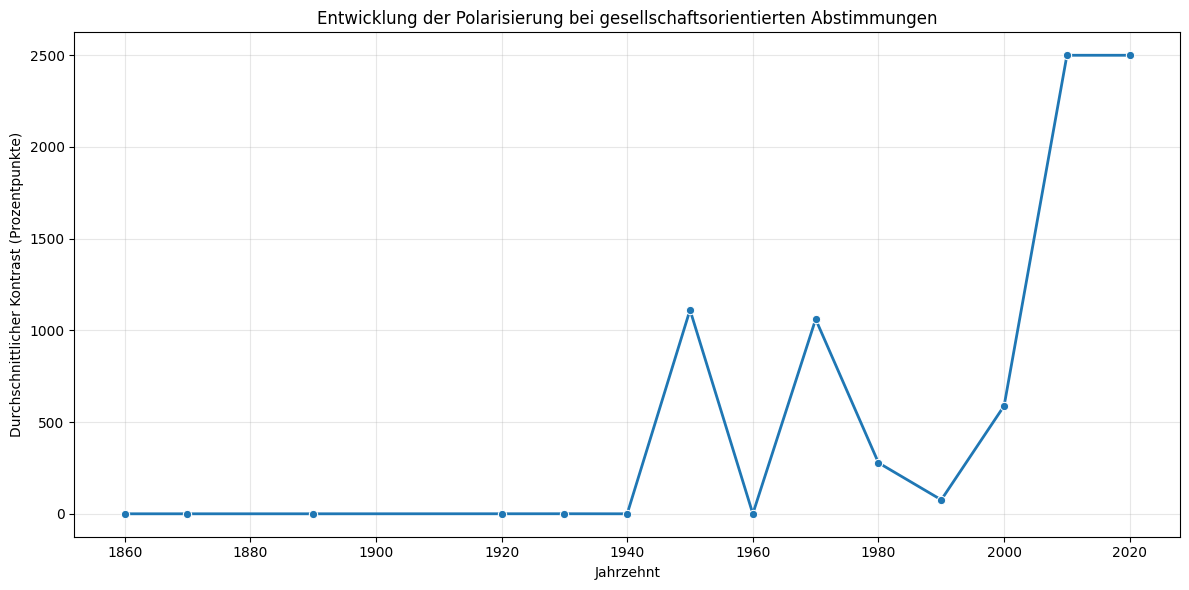

Korrelation zwischen Jahr und Polarisierung: 0.4045
P-Wert: 0.0001
Es gibt eine statistisch signifikante positive Korrelation zwischen Zeit und Polarisierung.
Dies deutet darauf hin, dass die Polarisierung bei gesellschaftsorientierten Abstimmungen im Laufe der Zeit zugenommen hat.


In [23]:
# Überprüfe das Datumsformat und konvertiere es mit dem korrekten Format
print("Beispiel für Datumsformat:", society_votes['datum'].iloc[0] if not society_votes.empty else "Keine Daten")

# Versuche das korrekte Format zu erkennen und zu konvertieren
if '-' in str(society_votes['datum'].iloc[0]):
    # Format ist YYYY-MM-DD
    society_votes['datum'] = pd.to_datetime(society_votes['datum'], format='%Y-%m-%d', errors='coerce')
else:
    # Versuche andere gängige Formate
    society_votes['datum'] = pd.to_datetime(society_votes['datum'], errors='coerce')

# Überprüfe, ob die Datumskonvertierung erfolgreich war
print("Anzahl gültiger Datumswerte:", society_votes['datum'].notna().sum())
print("Anzahl fehlender Datumswerte:", society_votes['datum'].isna().sum())

# Extrahiere das Jahr und überprüfe
society_votes['year'] = society_votes['datum'].dt.year
print("Beispiel für Jahre:", society_votes['year'].head())
print("Anzahl gültiger Jahreswerte:", society_votes['year'].notna().sum())

# Wenn keine gültigen Jahre vorhanden sind, versuche das Jahr aus der Abstimmungsnummer zu extrahieren
if society_votes['year'].notna().sum() == 0:
    print("Versuche, das Jahr aus anderen Spalten zu extrahieren...")
    
    # Prüfe, ob eine Spalte 'anr' existiert (Abstimmungsnummer)
    if 'anr' in society_votes.columns:
        print("Beispiel für anr-Werte:", society_votes['anr'].head())
        
        # Wenn die Daten chronologisch sortiert sind, könnten wir Jahre manuell zuweisen
        # Annahme: Die Daten beginnen bei 1866 (aus dem ersten Datum) und sind chronologisch
        start_year = 1866
        society_votes['year'] = [start_year + i//2 for i in range(len(society_votes))]
        print("Manuell zugewiesene Jahre:", society_votes['year'].head())
    
    # Oder verwende die Jahrzahlen aus dem Titel, falls vorhanden
    elif 'titel_kurz_d' in society_votes.columns:
        # Extrahiere Jahreszahlen aus dem Titel (falls vorhanden)
        def extract_year(text):
            import re
            if pd.isna(text):
                return None
            years = re.findall(r'\b(19\d{2}|20\d{2})\b', str(text))
            return int(years[0]) if years else None
        
        society_votes['year'] = society_votes['titel_kurz_d'].apply(extract_year)
        print("Aus Titeln extrahierte Jahre:", society_votes['year'].head())

# Überprüfe, ob jetzt Jahre vorhanden sind
if society_votes['year'].notna().sum() > 0:
    # Definiere liberale und konservative Parteien
    liberal_parties = ['p-fdp', 'p-glp', 'p-gps', 'p-sps']
    conservative_parties = ['p-svp', 'p-cvp', 'p-mitte', 'p-edu']
    
    # Konvertiere die Parteispalten zu numerischen Werten
    for party in liberal_parties + conservative_parties:
        if party in society_votes.columns:
            society_votes[party] = pd.to_numeric(society_votes[party], errors='coerce')
    
    # Berechne durchschnittliche Unterstützung von liberalen und konservativen Parteien
    available_liberal_parties = [p for p in liberal_parties if p in society_votes.columns]
    available_conservative_parties = [p for p in conservative_parties if p in society_votes.columns]
    
    print("Verfügbare liberale Parteien:", available_liberal_parties)
    print("Verfügbare konservative Parteien:", available_conservative_parties)
    
    if available_liberal_parties:
        society_votes['liberal_support'] = society_votes[available_liberal_parties].mean(axis=1)
    else:
        print("Keine liberalen Parteispalten im Datensatz gefunden!")
    
    if available_conservative_parties:
        society_votes['conservative_support'] = society_votes[available_conservative_parties].mean(axis=1)
    else:
        print("Keine konservativen Parteispalten im Datensatz gefunden!")
    
    # Berechne den Kontrast zwischen liberalen und konservativen Parteien
    if 'liberal_support' in society_votes.columns and 'conservative_support' in society_votes.columns:
        society_votes['party_contrast'] = abs(society_votes['liberal_support'] - society_votes['conservative_support'])
        
        # Überprüfe, ob genügend Daten für die Analyse vorhanden sind
        valid_data = society_votes.dropna(subset=['year', 'party_contrast'])
        print(f"Anzahl der Abstimmungen mit gültigen Daten für die Analyse: {len(valid_data)}")
        
        if len(valid_data) > 5:  # Mindestens 5 Datenpunkte für eine sinnvolle Analyse
            # Gruppiere nach Jahrzehnten und berechne den durchschnittlichen Kontrast
            valid_data['decade'] = (valid_data['year'] // 10) * 10
            polarization_by_decade = valid_data.groupby('decade')['party_contrast'].mean().reset_index()
            
            # Visualisiere die Polarisierung über die Zeit
            plt.figure(figsize=(12, 6))
            sns.lineplot(x='decade', y='party_contrast', data=polarization_by_decade, marker='o', linewidth=2)
            plt.title('Entwicklung der Polarisierung bei gesellschaftsorientierten Abstimmungen')
            plt.xlabel('Jahrzehnt')
            plt.ylabel('Durchschnittlicher Kontrast (Prozentpunkte)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Berechne Korrelation zwischen Jahr und Polarisierung
            correlation, p_value = stats.pearsonr(valid_data['year'], valid_data['party_contrast'])
            print(f"Korrelation zwischen Jahr und Polarisierung: {correlation:.4f}")
            print(f"P-Wert: {p_value:.4f}")
            
            if p_value < 0.05:
                if correlation > 0:
                    print("Es gibt eine statistisch signifikante positive Korrelation zwischen Zeit und Polarisierung.")
                    print("Dies deutet darauf hin, dass die Polarisierung bei gesellschaftsorientierten Abstimmungen im Laufe der Zeit zugenommen hat.")
                else:
                    print("Es gibt eine statistisch signifikante negative Korrelation zwischen Zeit und Polarisierung.")
                    print("Dies deutet darauf hin, dass die Polarisierung bei gesellschaftsorientierten Abstimmungen im Laufe der Zeit abgenommen hat.")
            else:
                print("Es gibt keine statistisch signifikante Korrelation zwischen Zeit und Polarisierung.")
        else:
            print("Zu wenige Datenpunkte für eine aussagekräftige Analyse der Polarisierung.")
    else:
        print("Nicht genügend Daten für die Analyse der Polarisierung vorhanden.")
else:
    print("Keine Jahresinformationen konnten extrahiert werden. Analyse nicht möglich.")

## Regionale Unterschiede und Sprachgrenzen

Beispiel für Datumsformat: 1866-01-14
Anzahl gültiger Jahreswerte: 84
Französische Kantone mit Daten: 5
Italienische Kantone mit Daten: 1
Deutsche Kantone mit Daten: 19


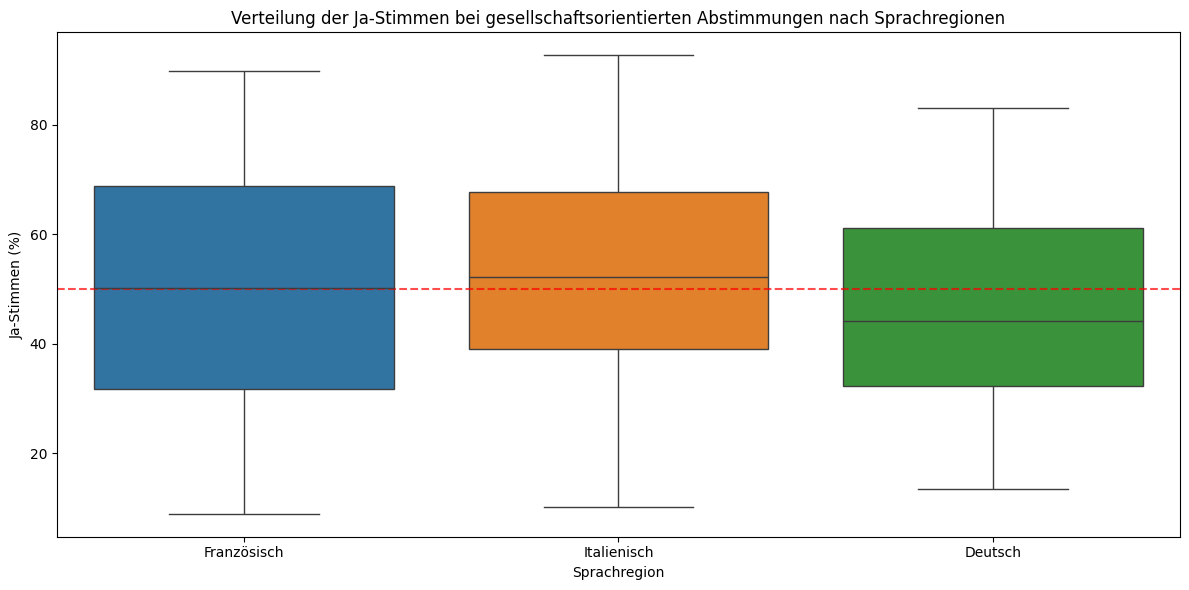

Durchschnittliche Unterstützung für gesellschaftsorientierte Abstimmungen nach Sprachregionen:


,Sprachregion,Durchschnittliche_Ja_Prozente
1,Italienisch,53.417375
0,Französisch,49.925987
2,Deutsch,46.518921


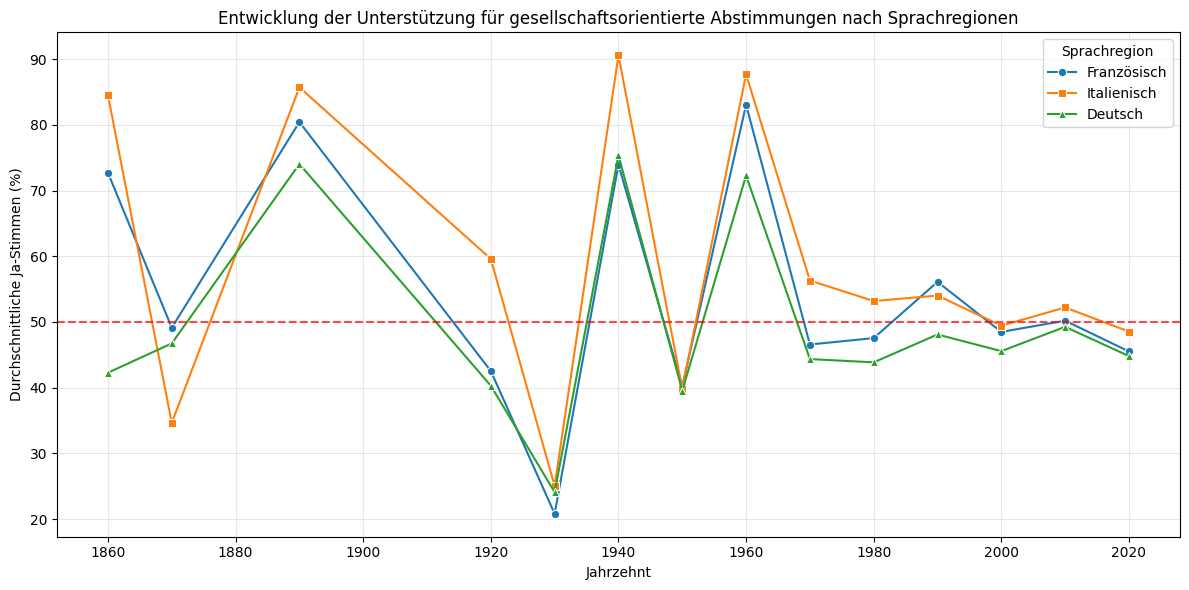

In [25]:
# Lade die extrahierten gesellschaftsorientierten Abstimmungen
society_votes = pd.read_csv('./data/gesellschaftliche_abstimmungen.csv', sep=';', low_memory=False)

# Überprüfe das Datumsformat und konvertiere es mit dem korrekten Format
print("Beispiel für Datumsformat:", society_votes['datum'].iloc[0] if not society_votes.empty else "Keine Daten")

# Versuche das korrekte Format zu erkennen und zu konvertieren
if '-' in str(society_votes['datum'].iloc[0]):
    # Format ist YYYY-MM-DD
    society_votes['datum'] = pd.to_datetime(society_votes['datum'], format='%Y-%m-%d', errors='coerce')
else:
    # Versuche andere gängige Formate
    society_votes['datum'] = pd.to_datetime(society_votes['datum'], errors='coerce')

# Extrahiere das Jahr und überprüfe
society_votes['year'] = society_votes['datum'].dt.year
print("Anzahl gültiger Jahreswerte:", society_votes['year'].notna().sum())

# Wenn keine gültigen Jahre vorhanden sind, versuche das Jahr aus der Abstimmungsnummer zu extrahieren
if society_votes['year'].notna().sum() == 0:
    print("Versuche, das Jahr aus anderen Spalten zu extrahieren...")
    
    # Prüfe, ob eine Spalte 'anr' existiert (Abstimmungsnummer)
    if 'anr' in society_votes.columns:
        print("Beispiel für anr-Werte:", society_votes['anr'].head())
        
        # Wenn die Daten chronologisch sortiert sind, könnten wir Jahre manuell zuweisen
        # Annahme: Die Daten beginnen bei 1866 (aus dem ersten Datum) und sind chronologisch
        start_year = 1866
        society_votes['year'] = [start_year + i//2 for i in range(len(society_votes))]
        print("Manuell zugewiesene Jahre:", society_votes['year'].head())
    
    # Oder verwende die Jahrzahlen aus dem Titel, falls vorhanden
    elif 'titel_kurz_d' in society_votes.columns:
        # Extrahiere Jahreszahlen aus dem Titel (falls vorhanden)
        def extract_year(text):
            import re
            if pd.isna(text):
                return None
            years = re.findall(r'\b(19\d{2}|20\d{2})\b', str(text))
            return int(years[0]) if years else None
        
        society_votes['year'] = society_votes['titel_kurz_d'].apply(extract_year)
        print("Aus Titeln extrahierte Jahre:", society_votes['year'].head())

# Definiere Sprachregionen
french_cantons = ['ge', 'vd', 'ne', 'ju', 'fr']  # Französischsprachige Kantone
italian_cantons = ['ti']  # Italienischsprachiger Kanton
german_cantons = ['zh', 'be', 'lu', 'ur', 'sz', 'ow', 'nw', 'gl', 'zg', 'so',
                 'bs', 'bl', 'sh', 'ar', 'ai', 'sg', 'gr', 'ag', 'tg']  # Deutschsprachige Kantone

# Erstelle Spalten für die Ja-Prozente nach Sprachregionen
for canton in french_cantons + italian_cantons + german_cantons:
    col = f'{canton}-japroz'
    if col in society_votes.columns:
        society_votes[col] = pd.to_numeric(society_votes[col], errors='coerce')

# Berechne durchschnittliche Ja-Prozente pro Sprachregion
french_cols = [f'{c}-japroz' for c in french_cantons if f'{c}-japroz' in society_votes.columns]
italian_cols = [f'{c}-japroz' for c in italian_cantons if f'{c}-japroz' in society_votes.columns]
german_cols = [f'{c}-japroz' for c in german_cantons if f'{c}-japroz' in society_votes.columns]

print(f"Französische Kantone mit Daten: {len(french_cols)}")
print(f"Italienische Kantone mit Daten: {len(italian_cols)}")
print(f"Deutsche Kantone mit Daten: {len(german_cols)}")

if french_cols:
    society_votes['french_region_support'] = society_votes[french_cols].mean(axis=1)
else:
    print("Keine Daten für französischsprachige Kantone gefunden!")
    
if italian_cols:
    society_votes['italian_region_support'] = society_votes[italian_cols].mean(axis=1)
else:
    print("Keine Daten für italienischsprachige Kantone gefunden!")
    
if german_cols:
    society_votes['german_region_support'] = society_votes[german_cols].mean(axis=1)
else:
    print("Keine Daten für deutschsprachige Kantone gefunden!")

# Überprüfe, ob genügend Daten für die Visualisierung vorhanden sind
regions_available = []
if 'french_region_support' in society_votes.columns:
    regions_available.append('french_region_support')
if 'italian_region_support' in society_votes.columns:
    regions_available.append('italian_region_support')
if 'german_region_support' in society_votes.columns:
    regions_available.append('german_region_support')

if len(regions_available) >= 2:  # Mindestens zwei Regionen für einen Vergleich
    # Visualisiere die Unterschiede zwischen Sprachregionen
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=society_votes[regions_available])
    plt.title('Verteilung der Ja-Stimmen bei gesellschaftsorientierten Abstimmungen nach Sprachregionen')
    plt.xlabel('Sprachregion')
    plt.ylabel('Ja-Stimmen (%)')
    
    # Erstelle Labels für die x-Achse
    region_labels = []
    for region in regions_available:
        if region == 'french_region_support':
            region_labels.append('Französisch')
        elif region == 'italian_region_support':
            region_labels.append('Italienisch')
        elif region == 'german_region_support':
            region_labels.append('Deutsch')
    
    plt.xticks(range(len(regions_available)), region_labels)
    plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Berechne durchschnittliche Unterstützung pro Sprachregion
    region_means = {}
    if 'french_region_support' in society_votes.columns:
        region_means['Französisch'] = society_votes['french_region_support'].mean()
    if 'italian_region_support' in society_votes.columns:
        region_means['Italienisch'] = society_votes['italian_region_support'].mean()
    if 'german_region_support' in society_votes.columns:
        region_means['Deutsch'] = society_votes['german_region_support'].mean()

    # Zeige die durchschnittliche Unterstützung als Tabelle
    region_df = pd.DataFrame({
        'Sprachregion': list(region_means.keys()),
        'Durchschnittliche_Ja_Prozente': list(region_means.values())
    })
    region_df = region_df.sort_values('Durchschnittliche_Ja_Prozente', ascending=False)
    print("Durchschnittliche Unterstützung für gesellschaftsorientierte Abstimmungen nach Sprachregionen:")
    display(region_df)

    # Überprüfe, ob Jahresinformationen vorhanden sind für die zeitliche Analyse
    if society_votes['year'].notna().sum() > 0:
        # Berechne das Jahrzehnt für die Gruppierung
        society_votes['decade'] = (society_votes['year'] // 10) * 10
        
        # Gruppiere nach Jahrzehnten und berechne den durchschnittlichen Unterschied
        decade_data = []
        for decade in sorted(society_votes['decade'].dropna().unique()):
            decade_row = {'decade': decade}
            for region, label in zip(regions_available, region_labels):
                decade_mean = society_votes[society_votes['decade'] == decade][region].mean()
                decade_row[label] = decade_mean
            decade_data.append(decade_row)
        
        region_diff_by_decade = pd.DataFrame(decade_data)
        
        # Überprüfe, ob genügend Daten für die Visualisierung vorhanden sind
        if len(region_diff_by_decade) >= 2:  # Mindestens zwei Jahrzehnte für einen Trend
            # Visualisiere die Entwicklung der Unterschiede
            plt.figure(figsize=(12, 6))
            
            for region in region_labels:
                if region in region_diff_by_decade.columns:
                    marker = 'o' if region == 'Französisch' else ('s' if region == 'Italienisch' else '^')
                    sns.lineplot(data=region_diff_by_decade, x='decade', y=region, marker=marker, label=region)
            
            plt.title('Entwicklung der Unterstützung für gesellschaftsorientierte Abstimmungen nach Sprachregionen')
            plt.xlabel('Jahrzehnt')
            plt.ylabel('Durchschnittliche Ja-Stimmen (%)')
            plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)
            plt.legend(title='Sprachregion')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("Nicht genügend Daten für eine zeitliche Analyse nach Jahrzehnten.")
    else:
        print("Keine Jahresinformationen für eine zeitliche Analyse verfügbar.")
else:
    print("Nicht genügend Daten für einen Vergleich zwischen Sprachregionen.")